# Import libraries

In [ ]:
!pip install bitermplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 615 kB 8.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.12-cp37-cp37m-linux_x86_64.whl size=939319 sha256=190014517912807bc6af5f2a7b83f4ff3159982b4e2460e175d2da353bf8ed28
  Stored in directory: /root/.cache/pip/wheels/76/8a/2f/de2ee90ae07b7cc412dd835313ba4c6a45cdba7971310577c1
Successfully built bitermplus


In [ ]:
!pip install tmplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for tmplot: filename=tmplot-0.0.8-py3-none-any.whl size=17293 sha256=a569c6b0dc06c34f76f7c04dbbc5893e6b08ad15f557939692e5677e005b3273
  Stored in directory: /root/.cache/pip/wheels/75/9c/0a/e186575ff76438e0dd78484634a86fbdde2bdf56bdea8ae007
Successfully built tmplot


In [ ]:
import bitermplus as btm
import numpy as np
import pandas as pd
import tmplot as tmp

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec

In [ ]:
!pip install -U gensim
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
abstracts = pd.read_csv("/content/drive/MyDrive/TFM_FINAL/prep_abstracts.csv",
                        index_col=0)
abstracts.Tokens = abstracts.Tokens.apply(eval)
texts = [' '.join(i) for i in abstracts.Tokens]

# Create biterms set

In [ ]:
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
biterms = btm.get_biterms(docs_vec)
diccionario = Dictionary(abstracts.Tokens)

# Hyperparameter tuning

## First round

In [ ]:
# Topics range
min_topics = 5
max_topics = 15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
alpha = [0.01, 0.1, 1, 10]
beta_aux = [1, 10, 20]
results = []
for k in topics_range:
  for b in beta_aux:
    for a in alpha:
      model = btm.BTM(X, vocabulary, seed=12321, T=k, M=10, alpha=a, beta=b/k)
      model.fit(biterms, iterations=50)
      words_topics = btm.get_top_topic_words(model)
      words_per_topic = words_topics.transpose().values.tolist()
      umass_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='u_mass')
      npmi_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='c_npmi')
      results.append([k, a, b/k, b, umass_btm.get_coherence(), npmi_btm.get_coherence()])
evaluation = pd.DataFrame(results, columns=['Number_topics', 'Alpha', 'Beta', 'Num', 'UMASS','NPMI'])

100%|██████████| 50/50 [00:11<00:00,  4.45it/s]


In [ ]:
with open("/content/drive/MyDrive/TFM_FINAL/hptuning_btm_abstract.csv", 'w', encoding = 'utf-8-sig') as f:
  evaluation.to_csv(f)

In [ ]:
evaluation.sort_values('UMASS', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
8,5,0.01,4.000000,20,-1.107472,0.017793
9,5,0.10,4.000000,20,-1.107472,0.017793
11,5,10.00,4.000000,20,-1.113880,0.017793
10,5,1.00,4.000000,20,-1.114323,0.017793
4,5,0.01,2.000000,10,-1.160935,0.010624
...,...,...,...,...,...,...
94,12,1.00,1.666667,20,-2.199197,0.016002
93,12,0.10,1.666667,20,-2.248966,0.019719
95,12,10.00,1.666667,20,-2.397940,0.013461
107,13,10.00,1.538462,20,-2.523264,0.006125


In [ ]:
evaluation.sort_values('NPMI', ascending=False)

,Number_topics,Alpha,Beta,Num,UMASS,NPMI
45,8,0.10,2.500000,20,-1.319829,0.036039
44,8,0.01,2.500000,20,-1.320277,0.036039
69,10,0.10,2.000000,20,-1.463953,0.035122
68,10,0.01,2.000000,20,-1.460736,0.034934
71,10,10.00,2.000000,20,-1.440610,0.034820
...,...,...,...,...,...,...
2,5,1.00,0.200000,1,-1.218296,0.009265
1,5,0.10,0.200000,1,-1.222194,0.009265
0,5,0.01,0.200000,1,-1.184616,0.008341
107,13,10.00,1.538462,20,-2.523264,0.006125


## Choosing best model

For the first time, UMASS and NPMI agree on best hyperparameters. We will compare beta = 20/K and alpha= 0.1, 0.01 and 10

In [ ]:
v1 = evaluation.loc[evaluation['Num']==20]
v1 = v1.loc[v1['Alpha']==0.1]
v2 = evaluation.loc[evaluation['Num']==20]
v2 = v2.loc[v2['Alpha']==0.01]
v3 = evaluation.loc[evaluation['Num']==20]
v3 = v3.loc[v3['Alpha']==10]

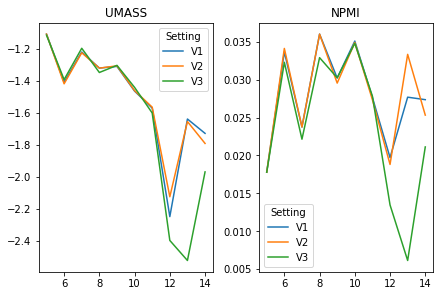

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,constrained_layout=True)

x = np.arange(5, 15, step=1)
ax1.plot(x,v1.UMASS,label='V1')
ax1.plot(x,v2.UMASS,label='V2')
ax1.plot(x,v3.UMASS,label='V3')
ax1.legend(title='Setting')
ax1.set_title('UMASS')

ax2.plot(x,v1.NPMI,label='V1')
ax2.plot(x,v2.NPMI,label='V2')
ax2.plot(x,v3.NPMI,label='V3')
ax2.legend(title='Setting')
ax2.set_title('NPMI')
#ax2.xticks(x)
plt.show()

We choose the model with k=8 topics, and V2 settings (i.e alpha=0.01 and beta = 20/k (note that this decission is totally subjective and another researcher may decide that this is not the most suitable model)

In [ ]:
model = btm.BTM(X, vocabulary, seed=12321, T=8, M=10, alpha=0.01, beta=20/8)
model.fit(biterms, iterations=50)
words_topics = btm.get_top_topic_words(model)
words_per_topic = words_topics.transpose().values.tolist()

100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


In [ ]:
umass_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='u_mass')
npmi_btm = CoherenceModel(topics=words_per_topic, texts=abstracts.Tokens, dictionary=diccionario,coherence='c_npmi')
umass = umass_btm.get_coherence()
npmi = npmi_btm.get_coherence()

In [ ]:
print('UMASS of final model:', umass)
print('NPMI of final model:', npmi)

UMASS of final model: -1.3202774606920784
NPMI of final model: 0.036038535443705166


# Analysis

In [ ]:
top_words = btm.get_top_topic_words(model)
top_words

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7
0,generat,model,dataset,imag,network,object,model,learn
1,model,train,human,segment,convolut,detect,achiev,algorithm
2,imag,task,art,network,graph,detector,state,polici
3,train,languag,state,featur,attent,propos,art,data
4,qualiti,learn,code,semant,model,point,perform,use
5,sampl,pre,result,task,propos,anchor,accuraci,train
6,high,text,system,object,neural,box,dataset,method
7,network,transform,benchmark,propos,learn,base,improv,reinforc
8,speech,perform,avail,learn,featur,stage,method,deep
9,gan,generat,evalu,method,layer,featur,result,optim


In [ ]:
tmp.report(model= model, docs=texts)

/usr/local/lib/python3.7/dist-packages/tmplot/_helpers.py:39: UserWarning: Please install "tomotopy" package to analyze its models.
Run `pip install tomotopy` in the console.
  f'Please install "{package_name}" package to analyze its models.\n'
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'squa

In [ ]:
prob_mat = model.transform(docs_vec)

100%|██████████| 891/891 [00:00<00:00, 2292.51it/s]


In [ ]:
abstracts['Topic'] = btm.get_docs_top_topic(texts, model.matrix_docs_topics_).label

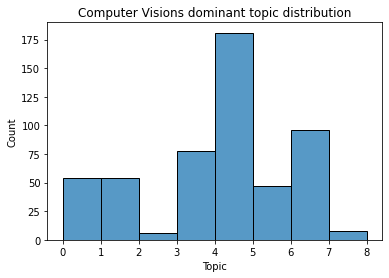

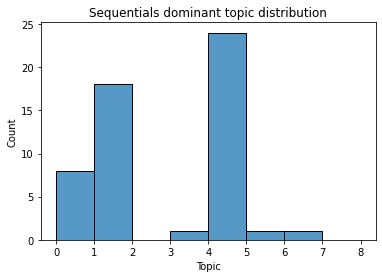

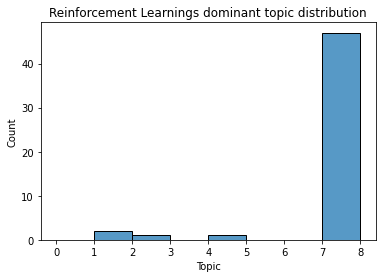

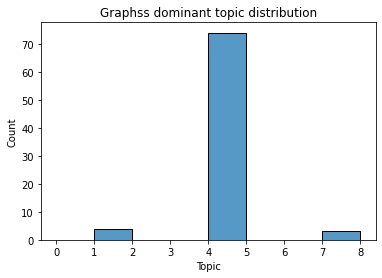

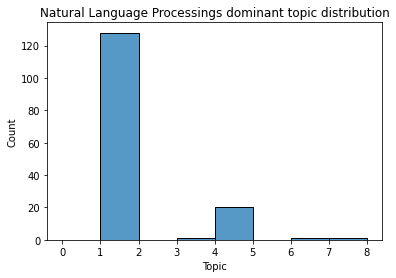

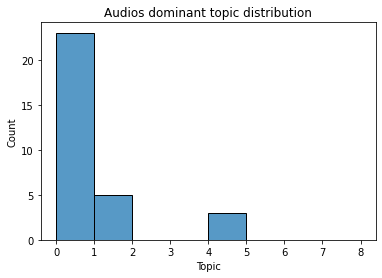

In [ ]:
labels = abstracts['label'].unique()
for lab in labels:
  df2 = abstracts[abstracts['label']==lab]
  sns.histplot(data=df2,x='Topic', binwidth=1,binrange=(0,8))
  plt.title(f'{lab}s dominant topic distribution')
  plt.show()

In [ ]:
Topic_1 = [] 
Confidence_1 = []
Topic_2 = []
Confidence_2 = []
for i in range(len(prob_mat)):
  ord = sorted(prob_mat[i],reverse=True)
  prob_1 = ord[0]
  prob_2 = ord[1]
  top_1 = np.where(prob_mat[i] == ord[0])
  Topic_1.append(int(top_1[0]))
  top_2 = np.where(prob_mat[i] == ord[1])
  Topic_2.append(int(top_2[0]))
  choices = ['High', 'Medium', 'Low']
  conditions_1 = [prob_1>=0.66, (prob_1<0.66) & (prob_1>=0.33),
                  prob_1<0.33]
  conf_1 = np.select(conditions_1,choices)
  Confidence_1.append(conf_1)
  conditions_2 = [prob_2>=0.66, (prob_2<0.66) & (prob_2>=0.33),
                  prob_2<0.33]
  conf_2 = np.select(conditions_2,choices)
  Confidence_2.append(conf_2)

In [ ]:
abstracts['Topic_1'] = Topic_1
abstracts['Confidence_1'] = Confidence_1
abstracts['Topic_2'] = Topic_2
abstracts['Confidence_2'] = Confidence_2
print(sum(abstracts['Topic_1'] == abstracts['Topic']))
abstracts.head()

891


,text,label,Tokens,Topic,Topic_1,Confidence_1,Topic_2,Confidence_2
0,sniper efficient multi scale training we prese...,Computer Vision,"[sniper, effici, multi, scale, train, present,...",3,3,Low,6,Low
1,temporal difference variational auto encoder t...,Sequential,"[tempor, differ, variat, auto, encod, act, pla...",4,4,Low,7,Low
2,mckernel library for approximate kernel expans...,Computer Vision,"[mckernel, librari, approxim, kernel, expans, ...",4,4,Low,7,Low
3,addressing function approximation error in act...,Reinforcement Learning,"[address, function, approxim, error, actor, cr...",7,7,Medium,4,Low
4,neural discrete representation learning learni...,Computer Vision,"[neural, discret, represent, learn, learn, use...",0,0,Low,4,Low


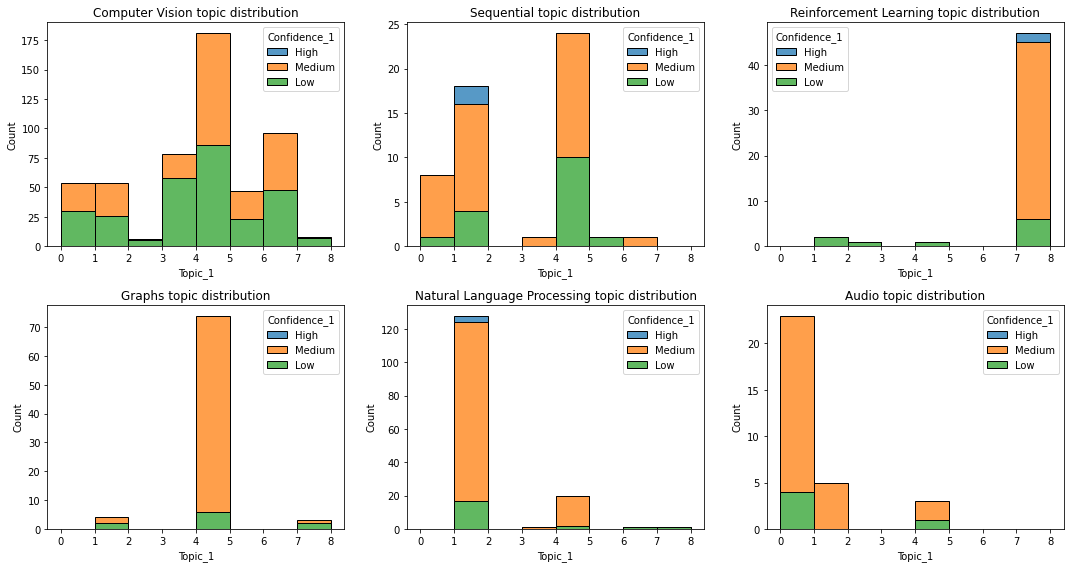

In [ ]:
for i in range(len(abstracts)):
  abstracts.loc[i,'Confidence_1'] = str(abstracts.loc[i,'Confidence_1'])
  abstracts.loc[i,'Confidence_2'] = str(abstracts.loc[i,'Confidence_2'])
plt.figure(figsize=(15,8), tight_layout=True)
labels = abstracts['label'].unique()
i = 1
for lab in labels:
  plt.subplot(2,3,i)
  i = i+1
  df3 = abstracts[abstracts['label']==lab]
  sns.histplot(data=df3,x='Topic_1', hue="Confidence_1", 
               multiple="stack", binwidth=1,binrange=(0,8), hue_order=['High', 'Medium', 'Low'])
  plt.title(f'{lab} topic distribution')
plt.show()

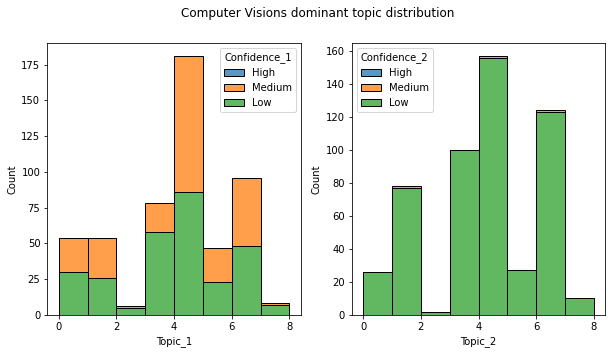

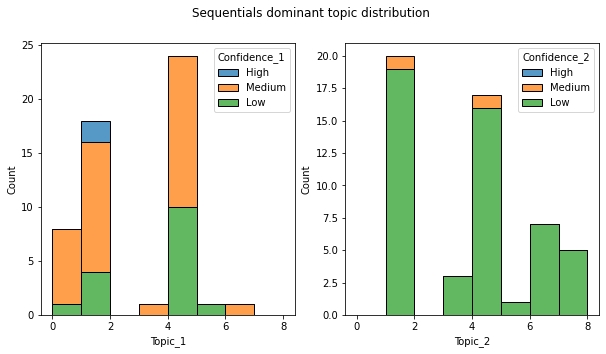

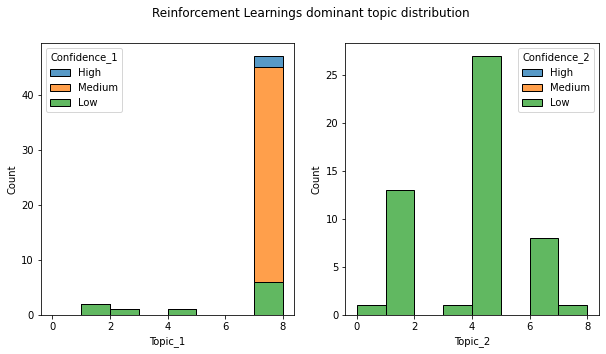

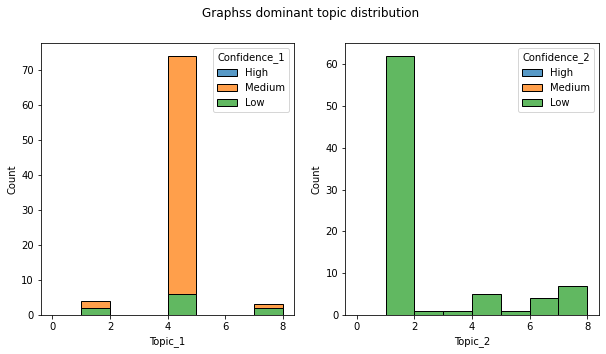

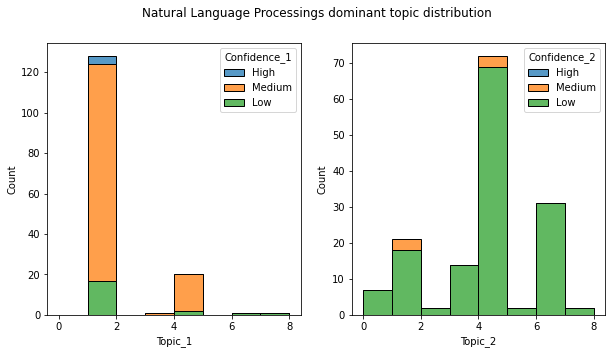

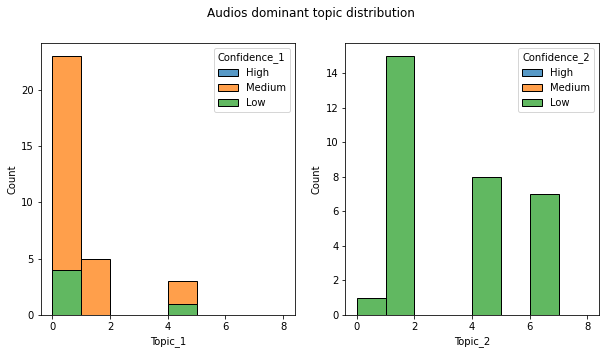

In [ ]:
for i in range(len(abstracts)):
  abstracts.loc[i,'Confidence_1'] = str(abstracts.loc[i,'Confidence_1'])
  abstracts.loc[i,'Confidence_2'] = str(abstracts.loc[i,'Confidence_2'])
labels = abstracts['label'].unique()
for lab in labels:
  df3 = abstracts[abstracts['label']==lab]
  fig = plt.figure(figsize=(10,5))
  fig.suptitle(f'{lab}s dominant topic distribution')
  gs = gridspec.GridSpec(nrows=1, 
                       ncols=2)
  ax1 = fig.add_subplot(gs[0, 0])
  sns.histplot(data=df3,x='Topic_1', hue="Confidence_1", 
               multiple="stack", binwidth=1,binrange=(0,8), hue_order=['High', 'Medium', 'Low'])
  ax2 = fig.add_subplot(gs[0, 1])
  sns.histplot(data=df3,x='Topic_2', hue="Confidence_2", 
               multiple="stack", binwidth=1,binrange=(0,8),hue_order=['High', 'Medium', 'Low'])
  plt.show()